## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

import cv2
from IPython.display import display
import ipywidgets as widgets
from glob import glob
import re
import json

import time
from concurrent.futures import ThreadPoolExecutor

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [3]:
import warnings

# Suppress the specific warning you are encountering
warnings.filterwarnings("ignore", message=r".*undefined symbol.*")

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

### Utils

In [9]:
rgb_frames_folder_suffix = "images"
mask_frames_folder_suffix = "masks"

In [6]:
def calculate_iou(pred_mask, gt_mask):
    """
    Calculate the IoU metric between the predicted mask and ground truth mask.
    
    Args:
    pred_mask (numpy array): The predicted mask.
    gt_mask (numpy array): The ground truth mask.
    
    Returns:
    float: IoU score.
    """
    # If tensored, convert to numpy array
    if torch.is_tensor(pred_mask):
        pred_mask = pred_mask.cpu().numpy()
    if torch.is_tensor(gt_mask):
        gt_mask = gt_mask.cpu().numpy

    # Convert the masks to boolean arrays
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0  # Handle edge cases
    
    iou = intersection / union
    return iou

def extract_number(file_path):
    # This regex captures numbers in various formats: after 'camera_', before '.jpg', '_i.npz', or 'i.npz'
    match = re.search(r'camera_(\d+)|(\d+)(?=\.jpg|_\d+\.npz|\.npz)', file_path)
    if match:
        # Return the camera number if it exists, otherwise return the frame or mask number
        return int(match.group(1) or match.group(2))
    return -1  # Return a default value in case no number is found


def convert_png_to_jpg(rgb_frames_dir, delete_png=True, suppress_output=True):
    for filename in os.listdir(rgb_frames_dir):
        if filename.endswith(".png"):
            # Open the PNG image
            png_image_path = os.path.join(rgb_frames_dir, filename)
            img = Image.open(png_image_path)
            
            # Convert the image mode to 'RGB' (PNG can have alpha channels)
            rgb_img = img.convert('RGB')
            
            # Save the image as a JPG
            new_filename = os.path.splitext(filename)[0] + ".jpg"
            jpg_image_path = os.path.join(rgb_frames_dir, new_filename)
            rgb_img.save(jpg_image_path, "JPEG")

            if delete_png:
                os.remove(png_image_path)
            
            if not suppress_output:
                print(f"Converted: {filename} to {new_filename}")

    if not suppress_output:
        print("Conversion complete!")

def process_camera_frames(camera_idx, n_cameras, frame_files, mask_files, color_merged_dir, mask_merged_dir):
    for j, (frame_file, mask_file) in enumerate(zip(frame_files, mask_files)):
        frame = cv2.imread(frame_file)
        mask = np.load(mask_file)['arr_0']
        
        # Define new frame and mask names based on camera and frame index
        frame_name = f"{camera_idx + j * n_cameras}.jpg"
        mask_name = f"{camera_idx + j * n_cameras}.npz"
        
        # Save the processed frame and mask
        cv2.imwrite(os.path.join(color_merged_dir, frame_name), frame)
        np.savez_compressed(os.path.join(mask_merged_dir, mask_name), mask)
    

# Main merging function
def merge_cameras_func(video_dir):
    camera_merged_dir = os.path.join(video_dir, "camera_merged")
    os.makedirs(camera_merged_dir, exist_ok=True)
    color_merged_dir = os.path.join(camera_merged_dir, rgb_frames_folder_suffix)
    os.makedirs(color_merged_dir, exist_ok=True)
    mask_merged_dir = os.path.join(camera_merged_dir, mask_frames_folder_suffix)
    os.makedirs(mask_merged_dir, exist_ok=True)

    items = sorted(os.listdir(video_dir))
    cameras = [item for item in items if (os.path.isdir(os.path.join(video_dir, item)) and item != "camera_merged")]
    cameras = sorted(cameras, key=extract_number)
    
    n_cameras = len(cameras)

    # Parallelize camera processing using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        for i, camera in enumerate(cameras):
            if camera == "camera_merged" or not os.path.isdir(os.path.join(video_dir, camera)):
                continue
            color_dir = os.path.join(video_dir, camera, rgb_frames_folder_suffix)
            mask_dir = os.path.join(video_dir, camera, mask_frames_folder_suffix)
            
            frame_files = sorted(glob(os.path.join(color_dir, "*.jpg")))
            frame_files = sorted(frame_files, key=extract_number)
            mask_files = sorted(glob(os.path.join(mask_dir, "*.npz")))
            mask_files = sorted(mask_files, key=extract_number)
            
            # Process each camera's frames and masks in parallel
            executor.submit(
                process_camera_frames, i, n_cameras, frame_files, mask_files, color_merged_dir, mask_merged_dir
            )

## Automatic Annotation

In [27]:
import shutil
videos_folder = "/home/lbocchi/UnA-Gen/data/3D_dress/00122/Outer"
mode = '3D_dress'
rgb_frames_folder_suffix = "images"
mask_frames_folder_suffix = "masks"

sequences_IoU = {}
rerun = True  # Set to True to rerun the entire process
merged = False

In [13]:
merge_sequences = False

if merge_sequences:
    print("videos folder:", sorted(os.listdir(videos_folder)))
    for video_folder in sorted(os.listdir(videos_folder)):  # Directory containing the video sequences
        sequence_folder = os.path.join(videos_folder, video_folder)  # Path to the sequence folder
        if merged:
            merged_camera_folder = os.path.join(sequence_folder, 'camera_merged')
            # Remove existing folder if it exists and rerun the merging process
            if os.path.exists(merged_camera_folder) and rerun:
                try:
                    shutil.rmtree(merged_camera_folder)
                except OSError as e:
                    print(f"Error: {e.strerror}, trying again in 1 second...")
                    time.sleep(1)  # Wait for a second and try again
                    try:
                        shutil.rmtree(merged_camera_folder)
                    except OSError as e:
                        print(f"Failed to remove {merged_camera_folder}: {e}")
            if not os.path.exists(merged_camera_folder) or rerun:
                os.makedirs(merged_camera_folder, exist_ok=True)
                merge_cameras_func(sequence_folder)

In [28]:
print("videos folder:", sorted(os.listdir(videos_folder)))
for video_folder in sorted(os.listdir(videos_folder)):  # Directory containing the video sequences
    if mode == '3D_dress':
        sequence_folder = os.path.join(videos_folder, video_folder, "Capture")  # Path to the sequence folder
    else:
        sequence_folder = os.path.join(videos_folder, video_folder)  # Path to the sequence folder
    if os.path.isdir(sequence_folder):
        if merged:
            merged_camera_folder = os.path.join(sequence_folder, 'camera_merged')
            '''
            # Remove existing folder if it exists and rerun the merging process
            if os.path.exists(merged_camera_folder) and rerun:
                try:
                    shutil.rmtree(merged_camera_folder)
                except OSError as e:
                    print(f"Error: {e.strerror}, trying again in 1 second...")
                    time.sleep(1)  # Wait for a second and try again
                    try:
                        shutil.rmtree(merged_camera_folder)
                    except OSError as e:
                        print(f"Failed to remove {merged_camera_folder}: {e}")
            if not os.path.exists(merged_camera_folder) or rerun:
                os.makedirs(merged_camera_folder, exist_ok=True)
                merge_cameras_func(sequence_folder)
            '''
        for camera_folder in sorted(os.listdir(sequence_folder)):  # Each camera folder in the sequence
            camera_folder_path = os.path.join(sequence_folder, camera_folder)
            print(f"Processing: {camera_folder_path}")
            if merged:
                process_cond = (camera_folder == 'camera_merged')
            else:
                process_cond = (camera_folder != 'camera_merged')

            if mode == 'dna_rendering':
                process_cond = process_cond and camera_folder.startswith('camera_')
            
            if os.path.isdir(camera_folder_path) and process_cond:
                video_dir = camera_folder_path
                gt_mask_folder = os.path.join(video_dir, mask_frames_folder_suffix)   # Assuming ground truth masks are saved with similar names
                if not os.path.exists(gt_mask_folder):  # This runs only if the ground truth mask folder exists to compute IoU
                    print(f"Ground truth mask folder not found: {gt_mask_folder}")
                    continue
                auto_mask_folder = os.path.join(video_dir, 'auto_predicted_masks')
                iou_file_path = os.path.join(camera_folder_path, 'iou.json')
                if os.path.exists(auto_mask_folder) and os.path.exists(iou_file_path) and not rerun:  # Skip if auto predicted mask folder already exists
                    with open(iou_file_path, "r") as f:
                        data = json.load(f)
                    sequences_IoU[data["camera_folder"]] = data["average_iou"]
                    continue
                
                t0 = time.time()
                frames_path = os.path.join(video_dir, rgb_frames_folder_suffix)  # Update this with your actual folder path
                
                # Convert PNG images to JPG
                convert_png_to_jpg(frames_path, delete_png=True, suppress_output=True)

                frame_files = sorted(glob(os.path.join(frames_path, "*.jpg")))  # List of frame image files
                frame_files = sorted(frame_files, key=extract_number)

                inference_state = predictor.init_state(video_path=frames_path)

                predictor.reset_state(inference_state)
                
                ann_frame_idx = 0  # the frame index we interact with
                ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

                # Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
                box = np.array([500, 500, 1500, 2000], dtype=np.float32)
                _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                    inference_state=inference_state,
                    frame_idx=ann_frame_idx,
                    obj_id=ann_obj_id,
                    box=box,
                )

                video_segments = {}  # video_segments contains the per-frame segmentation results
                for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
                    video_segments[out_frame_idx] = {
                        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                        for i, out_obj_id in enumerate(out_obj_ids)
                    }
                t1 = time.time()

                total_iou = 0.0
                count = 0
                for frame_idx in video_segments.keys():
                    gt_mask_path = os.path.join(gt_mask_folder, f'{frame_idx}.npz')
                    if os.path.exists(gt_mask_path):
                        gt_mask = np.load(gt_mask_path)['arr_0']  # Load ground truth mask
                        pred_masks = video_segments[frame_idx]
                        for obj_id, pred_mask in pred_masks.items():
                            iou = calculate_iou(pred_mask[0], gt_mask)
                            total_iou += iou
                            count += 1
                average_iou = total_iou / count if count > 0 else 0.0

                print(f"Average IoU: {average_iou}, sequence processing time: {t1 - t0:.2f} seconds")

                for frame_idx, pred_masks in video_segments.items():
                    for obj_id, pred_mask in pred_masks.items():
                        mask_folder = os.path.join(video_dir, 'auto_predicted_masks')
                        os.makedirs(mask_folder, exist_ok=True)
                        mask_path = os.path.join(mask_folder, f'{frame_idx}_{obj_id}.npz')
                        np.savez_compressed(mask_path, pred_mask)

                sequences_IoU[camera_folder] = average_iou
                # Save values to avoid repeating the sequence processing
                iou_file_path = os.path.join(camera_folder_path, 'iou.json')
                data = {
                    "camera_folder": camera_folder,
                    "average_iou": average_iou,
                    "sequence_processing_time": t1 - t0,
                }
                with open(iou_file_path, "w") as f:
                    json.dump(data, f)


videos folder: ['.DS_Store', '._.DS_Store', 'Take10', 'Take11', 'Take12', 'Take14', 'Take16', 'Take9']
Processing: /home/lbocchi/UnA-Gen/data/3D_dress/00122/Outer/Take10/Capture/0004
Converting PNG images to JPG for: /home/lbocchi/UnA-Gen/data/3D_dress/00122/Outer/Take10/Capture/0004/images


UnidentifiedImageError: cannot identify image file '/home/lbocchi/UnA-Gen/data/3D_dress/00122/Outer/Take10/Capture/0004/images/capture-f00049.png'

Average IoU across all sequences: 90.49%


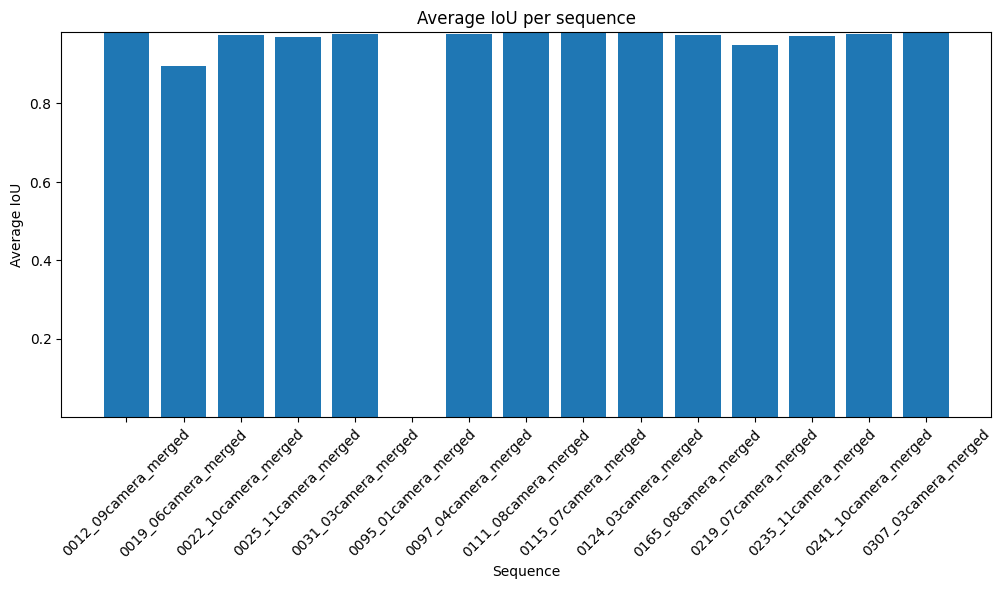

In [10]:
sequences_all = {}
processing_times = {}
for video_folder in sorted(os.listdir(videos_folder)):  # Directory containing the video sequences
    sequence_folder = os.path.join(videos_folder, video_folder)  # Path to the sequence folder
    for camera_folder in sorted(os.listdir(sequence_folder)):  # Each camera folder in the sequence
        camera_folder_path = os.path.join(sequence_folder, camera_folder)
        if merged:
            process_cond = (camera_folder == 'camera_merged')
        else:
            process_cond = (camera_folder != 'camera_merged')
        if os.path.isdir(camera_folder_path) and camera_folder.startswith('camera_') and process_cond:
            video_dir = camera_folder_path
            auto_mask_folder = os.path.join(video_dir, 'auto_predicted_masks')
            iou_file_path = os.path.join(camera_folder_path, 'iou.json')
            if os.path.exists(auto_mask_folder) and os.path.exists(iou_file_path):  # Skip if auto predicted mask folder already exists
                with open(iou_file_path, "r") as f:
                    data = json.load(f)
                sequences_all[video_folder+data["camera_folder"]] = data["average_iou"]  # Store the IoU value   
                processing_times[video_folder+data["camera_folder"]] = data["sequence_processing_time"]             

IoU_total = sum(sequences_all.values()) / len(sequences_all)
print(f"Average IoU across all sequences: {round(IoU_total*100, 2)}%")

# Visualize IoU scores
plt.figure(figsize=(12, 5))
plt.bar(sequences_all.keys(), sequences_all.values())
plt.ylim(min(sequences_all.values()), max(sequences_all.values()))
plt.xlabel("Sequence")
plt.ylabel("Average IoU")
plt.title("Average IoU per sequence")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Percentage of sequences with IoU > 0.95
IoU_95 = len([k for k, v in sequences_all.items() if v > 0.95]) / len(sequences_all) * 100
print(f"Percentage of sequences with IoU > 0.95: {round(IoU_95, 2)}%")

Percentage of sequences with IoU > 0.95: 80.0%


In [12]:
# Return the sequences and cameras where the IoU is below a certain threshold
threshold = 0.8
low_IoU_sequences = {k: v for k, v in sequences_all.items() if v < threshold}
print(f"Sequences with IoU below {threshold*100}%:")
for k, v in low_IoU_sequences.items():
    print(f"{k}: {round(v*100, 2)}%")

Sequences with IoU below 80.0%:
0095_01camera_merged: 0.02%


In [13]:
# Visualize the bad performance sequences
videos_folder = "/home/lbocchi/UnA-Gen/data/sam_val_dna"

# Get the list of sequence keys
sequence_keys = list(low_IoU_sequences.keys())

# Function to display the image based on the slider values
def display_image(sequence_idx, frame_idx):
    sequence_key = sequence_keys[sequence_idx]
    sequence_folder = os.path.join(videos_folder, sequence_key.split("camera", 1)[0], "camera" + sequence_key.split("camera", 1)[1])
    print("Sequence:", sequence_key.split("camera", 1)[0], "Camera:", sequence_key.split("camera", 1)[1])
    
    frame_folder = os.path.join(sequence_folder, rgb_frames_folder_suffix)
    masks_folder = os.path.join(sequence_folder, "auto_predicted_masks")
    
    frame_files = sorted(glob(os.path.join(frame_folder, "*.jpg")))
    frame_files = sorted(frame_files, key=extract_number)
    mask_files = sorted(glob(os.path.join(masks_folder, "*.npz")))
    mask_files = sorted(mask_files, key=extract_number)

    
    if frame_files:
        frame_file = frame_files[frame_idx]
        frame = cv2.imread(frame_file)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        box = np.array([500, 200, 1500, 2200], dtype=np.float32)
        show_box(box, plt.gca())
        mask = np.load(mask_files[frame_idx])['arr_0']
        show_mask(mask, plt.gca(), obj_id=0)
        plt.axis('off')
        plt.show()
    else:
        print(f"No frames found in {sequence_folder}")

# Create the sequence slider widget
sequence_slider = widgets.IntSlider(min=0, max=len(sequence_keys) - 1, step=1, description='Sequence Index')

# Create the frame slider widget
frame_slider = widgets.IntSlider(min=0, max=100, step=1, description='Frame Index')

# Update the frame slider max value based on the selected sequence
def update_frame_slider(*args):
    sequence_idx = sequence_slider.value
    sequence_key = sequence_keys[sequence_idx]
    sequence_folder = os.path.join(videos_folder, sequence_key.split("camera", 1)[0], "camera" + sequence_key.split("camera", 1)[1], rgb_frames_folder_suffix)
    
    # Get frame files for the selected sequence
    frame_files = sorted(glob(os.path.join(sequence_folder, "*.jpg")))
    
    # Set the frame slider's max value to the number of frames
    frame_slider.max = len(frame_files) - 1 if frame_files else 0

# Observe changes in the sequence slider and update the frame slider
sequence_slider.observe(update_frame_slider, 'value')

# Link the sliders to the display function
interactive_display = widgets.interactive(display_image, sequence_idx=sequence_slider, frame_idx=frame_slider)

# Display the interactive widgets
display(interactive_display)

interactive(children=(IntSlider(value=0, description='Sequence Index', max=0), IntSlider(value=0, description=…

In [14]:
# Return the sequences and cameras where the IoU is in a certain range
low_threshold = 0.8
high_threshold = 0.95
threshold_sequences = {k: v for k, v in sequences_all.items() if low_threshold <= v <= high_threshold}
print(f"Sequences with IoU between {low_threshold*100}% and {high_threshold*100}%:")
for k, v in threshold_sequences.items():
    print(f"{k}: {round(v*100, 2)}%")

Sequences with IoU between 80.0% and 95.0%:
0019_06camera_merged: 89.65%
0219_07camera_merged: 94.96%


In [15]:
# Visualize the sequences with IoU between the thresholds
# Visualize the bad performance sequences
videos_folder = "/home/lbocchi/UnA-Gen/data/sam_val_dna"

# Get the list of sequence keys
sequence_keys = list(threshold_sequences.keys())

# Function to display the image based on the slider values
def display_image(sequence_idx, frame_idx):
    sequence_key = sequence_keys[sequence_idx]
    sequence_folder = os.path.join(videos_folder, sequence_key.split("camera", 1)[0], "camera" + sequence_key.split("camera", 1)[1])
    print("Sequence:", sequence_key.split("camera", 1)[0], "Camera:", sequence_key.split("camera", 1)[1])
    
    frame_folder = os.path.join(sequence_folder, rgb_frames_folder_suffix
    masks_folder = os.path.join(sequence_folder, "auto_predicted_masks")
    
    frame_files = sorted(glob(os.path.join(frame_folder, "*.jpg")))
    frame_files = sorted(frame_files, key=extract_number)
    mask_files = sorted(glob(os.path.join(masks_folder, "*.npz")))
    mask_files = sorted(mask_files, key=extract_number)
    
    if frame_files:
        frame_file = frame_files[frame_idx]
        frame = cv2.imread(frame_file)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        box = np.array([500, 200, 1500, 2200], dtype=np.float32)
        show_box(box, plt.gca())
        mask = np.load(mask_files[frame_idx])['arr_0']
        show_mask(mask, plt.gca(), obj_id=0)
        plt.axis('off')
        plt.show()
    else:
        print(f"No frames found in {sequence_folder}")

# Create the sequence slider widget
sequence_slider = widgets.IntSlider(min=0, max=len(sequence_keys) - 1, step=1, description='Sequence Index')

# Create the frame slider widget
frame_slider = widgets.IntSlider(min=0, max=100, step=1, description='Frame Index')

# Update the frame slider max value based on the selected sequence
def update_frame_slider(*args):
    sequence_idx = sequence_slider.value
    sequence_key = sequence_keys[sequence_idx]
    sequence_folder = os.path.join(videos_folder, sequence_key.split("camera", 1)[0], "camera" + sequence_key.split("camera", 1)[1], rgb_frames_folder_suffix)
    
    # Get frame files for the selected sequence
    frame_files = sorted(glob(os.path.join(sequence_folder, "*.jpg")))
    
    # Set the frame slider's max value to the number of frames
    frame_slider.max = len(frame_files) - 1 if frame_files else 0

# Observe changes in the sequence slider and update the frame slider
sequence_slider.observe(update_frame_slider, 'value')

# Link the sliders to the display function
interactive_display = widgets.interactive(display_image, sequence_idx=sequence_slider, frame_idx=frame_slider)

# Display the interactive widgets
display(interactive_display)

interactive(children=(IntSlider(value=0, description='Sequence Index', max=1), IntSlider(value=0, description=…

## 3D Annotation

In [ ]:
import numpy as np
import open3d as o3d
import cv2  # For image processing

# Sample inputs:
# point_cloud: Open3D point cloud (e.g., loaded from a .ply file)
# cam_params: List of dictionaries with each camera's intrinsic and extrinsic matrices
# masks: List of 2D binary segmentation masks (numpy arrays), each corresponding to a camera view

def load_point_cloud(file_path):
    # Load point cloud from file
    point_cloud = o3d.io.read_point_cloud(file_path)
    return point_cloud

def project_points_to_camera(points, intrinsic, extrinsic):
    """ Project 3D points onto 2D camera plane using intrinsic and extrinsic matrices. """
    # Transform points to the camera's coordinate system
    points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))
    points_cam = (extrinsic @ points_homogeneous.T).T[:, :3]
    
    # Project using intrinsic matrix
    points_proj = (intrinsic @ points_cam.T).T
    points_proj /= points_proj[:, 2:3]  # Normalize by depth (z)
    
    return points_proj[:, :2]  # Return 2D projected points

def back_project_2d_masks_to_3d(point_cloud, cam_params, masks, mask_threshold=0.5):
    """
    Back-project 2D masks onto 3D point cloud.
    
    Args:
        point_cloud (o3d.geometry.PointCloud): The 3D point cloud of the scene.
        cam_params (list): List of camera parameters (each with 'intrinsic' and 'extrinsic').
        masks (list): List of 2D binary masks corresponding to each camera view.
        mask_threshold (float): Threshold for considering mask values as foreground.
        
    Returns:
        np.array: Array of labels for each 3D point in the point cloud.
    """
    num_points = np.asarray(point_cloud.points).shape[0]
    votes = np.zeros(num_points)  # Voting array for each 3D point
    labels = np.zeros(num_points, dtype=np.bool)  # Initial empty segmentation labels

    for i, (params, mask) in enumerate(zip(cam_params, masks)):
        intrinsic, extrinsic = params['intrinsic'], params['extrinsic']
        points = np.asarray(point_cloud.points)
        
        # Project points onto the current camera's 2D plane
        points_2d = project_points_to_camera(points, intrinsic, extrinsic).astype(np.int32)

        # Filter out points that project outside the mask boundaries
        mask_h, mask_w = mask.shape
        valid_idx = (
            (points_2d[:, 0] >= 0) & (points_2d[:, 0] < mask_w) &
            (points_2d[:, 1] >= 0) & (points_2d[:, 1] < mask_h)
        )
        valid_points = points[valid_idx]
        valid_points_2d = points_2d[valid_idx]
        
        # Get the mask values for projected points
        mask_values = mask[valid_points_2d[:, 1], valid_points_2d[:, 0]]
        
        # Mark points as segmented if they fall in the foreground region in this view
        votes[valid_idx] += mask_values > mask_threshold

    # Majority voting: points that are considered foreground in more than half of the views
    threshold = len(cam_params) / 2
    labels = votes > threshold
    
    return labels

# Example usage:
# Load point cloud
point_cloud = load_point_cloud("path_to_point_cloud.ply")

# Define camera parameters for each view (example)
cam_params = [
    {"intrinsic": np.array([[fx1, 0, cx1], [0, fy1, cy1], [0, 0, 1]]), "extrinsic": extrinsic_matrix1},
    {"intrinsic": np.array([[fx2, 0, cx2], [0, fy2, cy2], [0, 0, 1]]), "extrinsic": extrinsic_matrix2},
    # Add more camera parameters as needed
]

# Load masks (example)
masks = [
    cv2.imread("mask_view1.png", cv2.IMREAD_GRAYSCALE) / 255,
    cv2.imread("mask_view2.png", cv2.IMREAD_GRAYSCALE) / 255,
    # Add more masks corresponding to the camera views
]

# Back-project masks to obtain 3D segmentation
labels = back_project_2d_masks_to_3d(point_cloud, cam_params, masks)

# Apply labels to the point cloud for visualization
point_cloud.colors = o3d.utility.Vector3dVector(np.where(labels[:, None], [1, 0, 0], [0, 0, 1]))  # Red for foreground, blue for background

# Save or visualize
o3d.visualization.draw_geometries([point_cloud])
o3d.io.write_point_cloud("segmented_point_cloud.ply", point_cloud)

## Camera setup

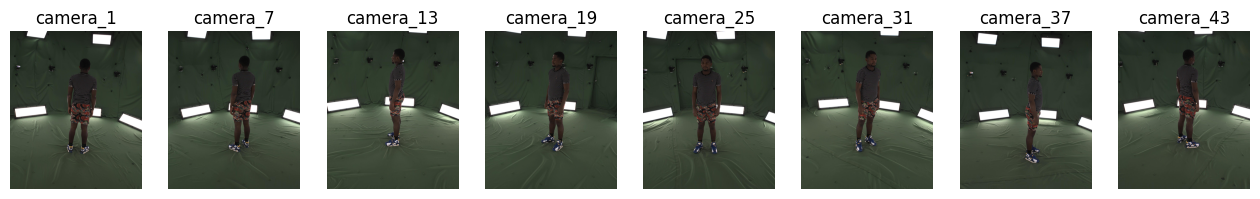

In [16]:
video_dir = "/home/lbocchi/UnA-Gen/data/sam_val_dna/0097_04"
items = sorted(os.listdir(video_dir))
cameras = [item for item in items if (os.path.isdir(os.path.join(video_dir, item)) and item.startswith("camera") and item != "camera_merged")]
cameras = sorted(cameras, key=extract_number)

fig, ax = plt.subplots(1, len(cameras), figsize=(16, 10))
for i, camera in enumerate(cameras):
    camera_dir = os.path.join(video_dir, camera)
    frame_files = sorted(glob(os.path.join(camera_dir, rgb_frames_folder_suffix, "*.jpg")))
    frame = cv2.imread(frame_files[0])
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax[i].imshow(frame_rgb)
    ax[i].axis("off")
    ax[i].set_title(camera)


In [22]:
merge_sequences = False   # We already processed the sequences above
merge_cameras = True  # Set to True to process all cameras in a single sequeence
video_dir = "/home/lbocchi/UnA-Gen/data/sam_val_dna/0019_06"
rgb_frames_folder_suffix = "images"
mask_frames_folder_suffix = "masks"

if merge_sequences:
    merge_cameras_func(video_dir)

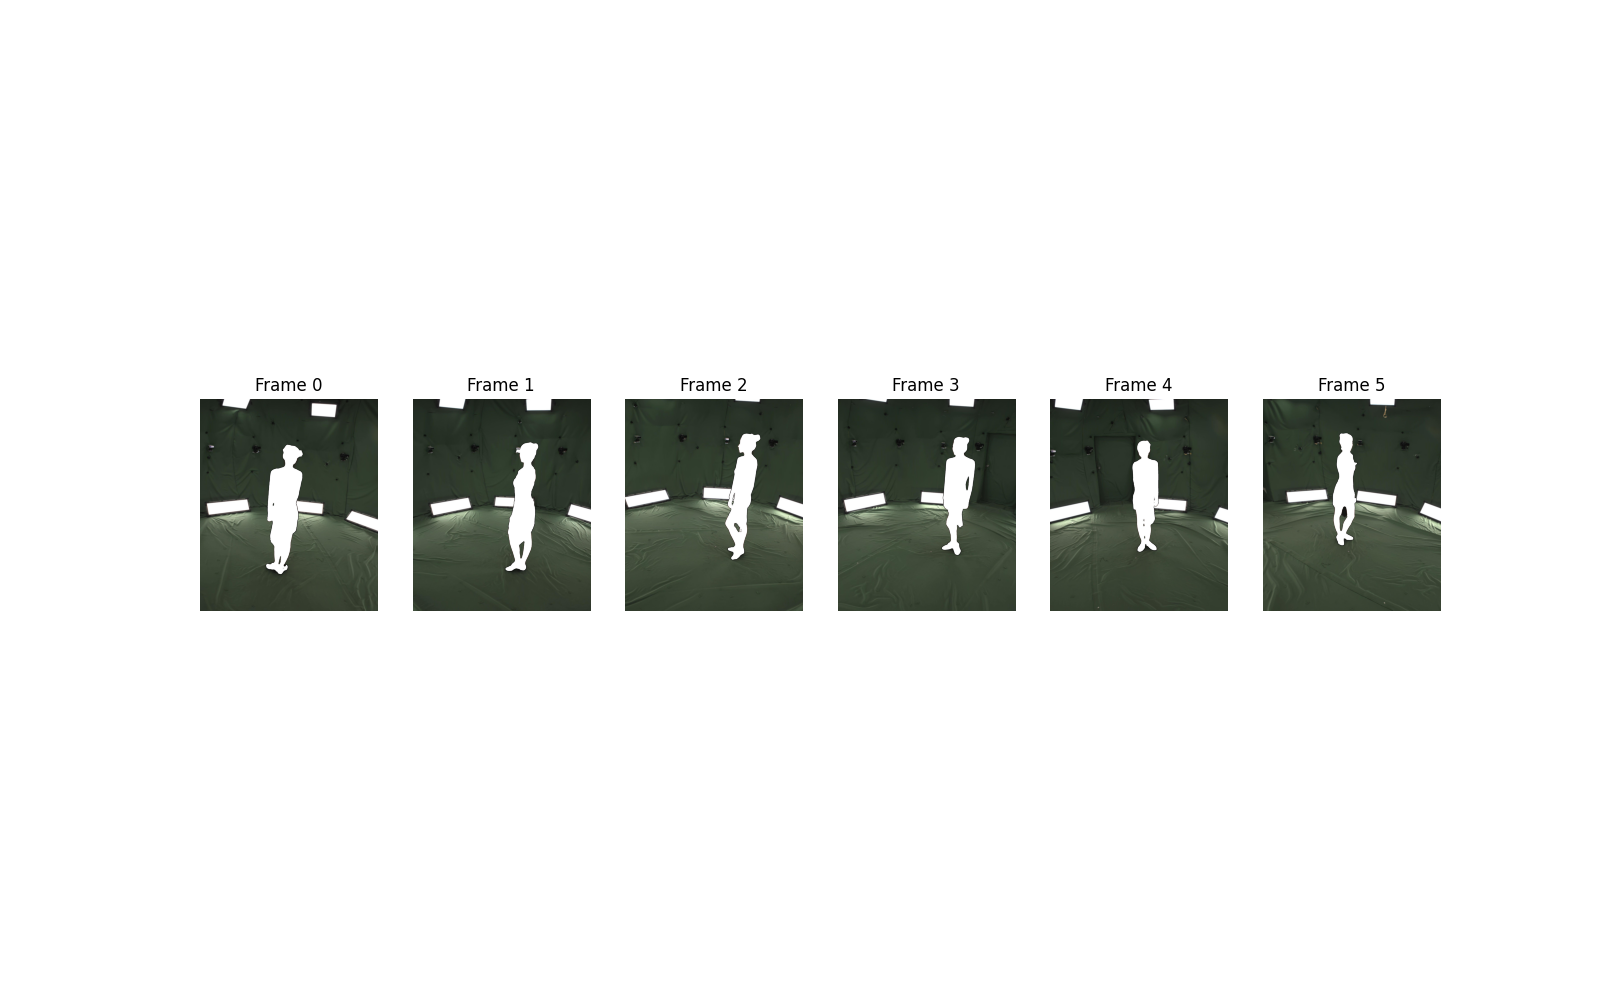

In [23]:
# Visualize the merged camera sequence and ground truth masks
sequence_dir = os.path.join(video_dir, "camera_merged")
frame_files = sorted(glob(os.path.join(sequence_dir, rgb_frames_folder_suffix, "*.jpg")))
frame_files = sorted(frame_files, key=extract_number)
mask_files = sorted(glob(os.path.join(sequence_dir, mask_frames_folder_suffix, "*.npz")))
mask_files = sorted(mask_files, key=extract_number)

fig, ax = plt.subplots(1, 6, figsize=(16, 10))
for i in range(6):
    frame = cv2.imread(frame_files[i])
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax[i].imshow(frame_rgb)
    ax[i].axis("off")
    ax[i].set_title(f"Frame {i}")
    mask = np.load(mask_files[i])['arr_0']
    show_mask(mask, ax[i], obj_id=0)

## Semi-Automatic Annotation Tool

In [25]:
%matplotlib widget

#os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [ ]:
video_dir = "/home/lbocchi/UnA-Gen/data/sam_val_dna/0008_01"
rgb_frames_dir = os.path.join(video_dir, rgb_frames_folder_suffix)

convert_png_to_jpg(rgb_frames_dir, delete_png=True, suppress_output=False)

inference_state = predictor.init_state(video_path=rgb_frames_dir)

Conversion complete!


frame loading (JPEG):   5%|▍         | 7/150 [00:00<00:14, 10.13it/s]

In [32]:
predictor.reset_state(inference_state)

# Path to the folder containing JPEG frames
frames_path = os.path.join(video_dir, rgb_frames_folder_suffix)  # Update this with your actual folder path
frame_files = sorted(glob(os.path.join(frames_path, "*.jpg")))  # List of frame image files
frame_files = sorted(frame_files, key=extract_number)

# Widget to display video frames
output = widgets.Output()

# Widget to display the next 3 frames (as previews)
preview_output_v = widgets.VBox([])

# Widget to display the next 6 frames (as previews)
preview_output_h = widgets.HBox([])

# A list to store clicked points for SAM input
mode = 'positive'
positive_points = []
negative_points = []
current_frame_idx = 0

video_segments = {}  # video_segments contains the per-frame segmentation results

# Function to handle mouse clicks on the frame
def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        # Append the clicked points to the list
        if mode == 'positive':
            positive_points.append((int(event.xdata), int(event.ydata)))
        elif mode == 'negative':
            negative_points.append((int(event.xdata), int(event.ydata)))       

def display_frame(frame_path):
    # Read the image frame using OpenCV
    frame = cv2.imread(frame_path)
    if frame is not None:
        # Convert the BGR frame (from OpenCV) to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(num=None, figsize=(7, 7), edgecolor='k')
        plt.imshow(frame_rgb)
        idx = extract_number(frame_path)
        if video_segments.get(idx) is not None:   # Add masks
            for out_obj_id, out_mask in video_segments[idx].items():
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.title(f"Frame: {os.path.basename(frame_path)} | Click to add points")
        plt.axis('off')
        plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)

        # Connect the click event to the figure
        fig = plt.gcf()
        fig.canvas.mpl_connect('button_press_event', on_click)
        plt.show()
    else:
        print(f"Error loading frame: {frame_path}")

def display_next_frames_preview_v(current_idx):
    """ Function to display the next 3 frames as previews """
    global video_segments
    preview_output_v.children = []  
    
    # Create preview images for the next 3 frames (if available)
    previews = []
    for i in range(1, 4):
        next_idx = current_idx + i
        if next_idx < len(frame_files):
            preview_frame_path = frame_files[next_idx]
            frame = cv2.imread(preview_frame_path)
            if frame is not None:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                fig, ax = plt.subplots(figsize=(4, 3))  # Small figure
                ax.imshow(frame_rgb)
                if video_segments.get(next_idx) is not None:   # Add masks
                    for out_obj_id, out_mask in video_segments[next_idx].items():
                        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
                ax.axis('off')  # Hide axis for previews
                previews.append(fig)
    
    # Update the preview area with the next 3 frame images
    preview_output_v.children = [widgets.Output() for _ in previews]
    for idx, preview_fig in enumerate(previews):
        with preview_output_v.children[idx]:
            display(preview_fig)
        plt.close(preview_fig)  

def display_next_frames_preview_h(current_idx):
    """ Function to display the next 3 frames as previews """
    global video_segments
    preview_output_h.children = []  
    
    # Create preview images for the next 3 frames (if available)
    previews = []
    for i in range(4, 10):
        next_idx = current_idx + i
        if next_idx < len(frame_files):
            preview_frame_path = frame_files[next_idx]
            frame = cv2.imread(preview_frame_path)
            if frame is not None:
                # Convert BGR to RGB and resize the frame
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Create a matplotlib figure for each preview
                fig, ax = plt.subplots(figsize=(3, 2))  # Small figure
                ax.imshow(frame_rgb)
                if video_segments.get(next_idx) is not None:   # Add masks
                    for out_obj_id, out_mask in video_segments[next_idx].items():
                        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
                ax.axis('off') 
                previews.append(fig)
    
    # Update the preview area with the next 3 frame images
    preview_output_h.children = [widgets.Output() for _ in previews]
    for idx, preview_fig in enumerate(previews):
        with preview_output_h.children[idx]:
            display(preview_fig)
        plt.close(preview_fig)  

def show_next_frame(b):
    global current_frame_idx
    with output:
        output.clear_output()  
        plt.close('all')
        if current_frame_idx+1 < len(frame_files):
            current_frame_idx += 1
            display_frame(frame_files[current_frame_idx])
            display_next_frames_preview_v(current_frame_idx)  # Update the next 3 frames preview
            display_next_frames_preview_h(current_frame_idx)  # Update the next 6 frames preview
        else:
            print("End of frames")

def show_previous_frame(b):
    global current_frame_idx
    with output:
        plt.close('all')
        output.clear_output()  # Clear the previous frame
        if current_frame_idx-1 >= 0:
            current_frame_idx -= 1
            display_frame(frame_files[current_frame_idx])
            display_next_frames_preview_v(current_frame_idx)  # Update the next 3 frames preview
            display_next_frames_preview_h(current_frame_idx)  # Update the next 6 frames preview
        else:
            print("Start of frames")

def show_next_10_frames(b):
    global current_frame_idx
    with output:
        plt.close('all')
        output.clear_output()
        if current_frame_idx+10 < len(frame_files):
            current_frame_idx += 10
            display_frame(frame_files[current_frame_idx])
            display_next_frames_preview_v(current_frame_idx)  # Update the next 3 frames preview
            display_next_frames_preview_h(current_frame_idx)  # Update the next 6 frames preview
        else:
            print("End of frames")

def show_previous_10_frames(b):
    global current_frame_idx
    with output:
        plt.close('all')
        output.clear_output()  # Clear the previous frame
        if current_frame_idx > 10:
            current_frame_idx -= 10
            display_frame(frame_files[current_frame_idx])
            display_next_frames_preview_v(current_frame_idx)  # Update the next 3 frames preview
            display_next_frames_preview_h(current_frame_idx)  # Update the next 6 frames preview
        else:
            print("Start of frames")

def show_current_frame(b):
    global current_frame_idx
    with output:
        plt.close('all')
        output.clear_output()  # Clear the previous frame
        display_frame(frame_files[current_frame_idx])
        display_next_frames_preview_v(current_frame_idx)  # Update the next 3 frames preview
        display_next_frames_preview_h(current_frame_idx)  # Update the next 6 frames preview

def clear_points(b):
    global video_segments
    global positive_points
    global negative_points
    with output:
        output.clear_output()
        predictor.reset_state(inference_state)
        positive_points = []
        negative_points = []
        video_segments = {}
        show_current_frame(None)

def predict_mask(b):
    global current_frame_idx
    global positive_points
    global negative_points
    with output:
        output.clear_output()
        if current_frame_idx >= 0:
            ann_frame_idx = current_frame_idx  # the frame index we interact with
            ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

            # Let's add a positive click at (x, y) = (210, 350) to get started
            pos_points = np.array(positive_points, dtype=np.float32)  # Fix points array
            neg_points = np.array(negative_points, dtype=np.float32)  # Fix points array
            if pos_points.shape[0] == 0:
                points = neg_points
            elif neg_points.shape[0] == 0:
                points = pos_points
            else:
                points = np.concatenate([pos_points, neg_points], axis=0)  # Concatenate positive and negative points
            
            # for labels, `1` means positive click and `0` means negative click
            pos_labels = np.ones(pos_points.shape[0], dtype=np.int32)  # Ensure labels match the number of points
            neg_labels = np.zeros(neg_points.shape[0], dtype=np.int32)  # Ensure labels match the number of points
            if pos_labels.shape[0] == 0:
                labels = neg_labels
            elif neg_labels.shape[0] == 0:
                labels = pos_labels
            else:
                labels = np.concatenate([pos_labels, neg_labels], axis=0)  # Concatenate positive and negative labels
            
            # Proceed with prediction using SAM
            _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=ann_frame_idx,
                obj_id=ann_obj_id,
                points=points,
                labels=labels,
            )

            # Show the results on the current (interacted) frame
            plt.close('all')
            plt.figure(num=None, figsize=(7, 7), edgecolor='k')
            plt.title(f"frame {ann_frame_idx}")
            plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
            plt.imshow(Image.open(os.path.join(video_dir, frame_files[ann_frame_idx])))
            show_points(points, labels, plt.gca())
            show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
            # Connect the click event to the figure
            fig = plt.gcf()
            fig.canvas.mpl_connect('button_press_event', on_click)
            plt.show()

            display_iou((out_mask_logits[0] > 0.0), ann_frame_idx)  # Display IoU if ground truth is available

def propagate_mask(b):
    global video_segments
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    display_average_iou()
    display_next_frames_preview_v(current_frame_idx) 
    display_next_frames_preview_h(current_frame_idx)   

def select_positive(b):
    global mode
    mode = 'positive'
    positive_button.button_style = 'success'  # Highlight the positive button
    negative_button.button_style = ''         # Reset the negative button style

def select_negative(b):
    global mode
    mode = 'negative'
    negative_button.button_style = 'danger'   # Highlight the negative button
    positive_button.button_style = ''         # Reset the positive button style

def bbox_prediction(b):
    global current_frame_idx
    with output:
        output.clear_output()
        if current_frame_idx >= 0:
            ann_frame_idx = current_frame_idx
            ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

            # Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
            box = np.array([500, 200, 1500, 2200], dtype=np.float32)
            _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=ann_frame_idx,
                obj_id=ann_obj_id,
                box=box,
            )

            # Show the results on the current (interacted) frame
            plt.close('all')
            plt.figure(num=None, figsize=(7, 7), edgecolor='k')
            plt.title(f"frame {ann_frame_idx}")
            plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
            plt.imshow(Image.open(os.path.join(video_dir, frame_files[ann_frame_idx])))
            show_box(box, plt.gca())
            show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
            # Connect the click event to the figure
            fig = plt.gcf()
            fig.canvas.mpl_connect('button_press_event', on_click)
            plt.show()

            display_iou((out_mask_logits[0] > 0.0), ann_frame_idx)  # Display IoU if ground truth is available

iou_label = widgets.Label(value="IoU: predict mask to compute")
average_iou_label = widgets.Label(value="A_IoU: propagate mask to compute")

def display_iou(pred_mask, frame_idx):
    """
    Display IoU if ground truth is available for the current frame.
    
    Args:
    pred_mask (numpy array): The predicted mask.
    frame_idx (int): Index of the current frame.
    """
    # Check if a ground truth mask is available for the current frame
    gt_mask_folder = os.path.join(video_dir, mask_frames_folder_suffix)   # Assuming ground truth masks are saved with similar names
    gt_mask_path = os.path.join(gt_mask_folder, f'{frame_idx}.npz')
    if os.path.exists(gt_mask_path):
        gt_mask = np.load(gt_mask_path)['arr_0']  # Load ground truth mask
        iou = calculate_iou(pred_mask.cpu()[0], gt_mask)
        iou_label.value = f"IoU: {iou:.4f}"
    else:
        iou_label.value = "IoU: N/A"  # No ground truth available

def display_average_iou():
    """
    Display the average IoU score for the propagated masks.
    """
    gt_mask_folder = os.path.join(video_dir, mask_frames_folder_suffix)   # Assuming ground truth masks are saved with similar names
    total_iou = 0.0
    count = 0
    for frame_idx in video_segments.keys():
        gt_mask_path = os.path.join(gt_mask_folder, f'{frame_idx}.npz')
        if os.path.exists(gt_mask_path):
            gt_mask = np.load(gt_mask_path)['arr_0']  # Load ground truth mask
            pred_masks = video_segments[frame_idx]
            for obj_id, pred_mask in pred_masks.items():
                iou = calculate_iou(pred_mask[0], gt_mask)
                total_iou += iou
                count += 1
    average_iou = total_iou / count if count > 0 else 0.0
    average_iou_label.value = f"A_IoU: {average_iou:.4f}"

def save_masks(b):
    """
    Save the predicted masks to the disk.
    """
    for frame_idx, pred_masks in video_segments.items():
        for obj_id, pred_mask in pred_masks.items():
            mask_folder = os.path.join(video_dir, 'predicted_masks')
            os.makedirs(mask_folder, exist_ok=True)
            mask_path = os.path.join(mask_folder, f'{frame_idx}_{obj_id}.npz')
            np.savez_compressed(mask_path, pred_mask)

# Button to move to the next frame
next_button = widgets.Button(description="Next Frame")
next_button.on_click(show_next_frame)

# Button to move to the previous frame
prev_button = widgets.Button(description="Previous Frame")
prev_button.on_click(show_previous_frame)

# Button to move to the next 10 frames
next_10_button = widgets.Button(description="Next 10 Frames")
next_10_button.on_click(show_next_10_frames)

# Button to move to the previous 10 frames
prev_10_button = widgets.Button(description="Previous 10 Frames")
prev_10_button.on_click(show_previous_10_frames)

# Button to bbox prediction
bbox_button = widgets.Button(description="BBox Prediction", button_style='info')
bbox_button.on_click(bbox_prediction)

# Button to select positive points
positive_button = widgets.Button(description="Positive Points", button_style='success')
positive_button.on_click(select_positive)

# Button to select negative points
negative_button = widgets.Button(description="Negative Points")
negative_button.on_click(select_negative)

# Button to clear the clicked points
clear_button = widgets.Button(description="Clear Points")
clear_button.on_click(clear_points)

# Button to predict mask
predict_button = widgets.Button(description="Predict Mask")
predict_button.on_click(predict_mask)

# Button to propagate mask
propagate_button = widgets.Button(description="Propagate Masks")
propagate_button.on_click(propagate_mask)

# Button to save the predicted masks
save_button = widgets.Button(description="Save Masks")
save_button.on_click(save_masks)

# Display the video frame and control buttons
# Create a vertical box for the buttons
button_box = widgets.VBox([prev_10_button, prev_button, next_button, next_10_button, 
                           bbox_button, positive_button, negative_button, clear_button, predict_button, propagate_button, 
                           iou_label, average_iou_label,
                           save_button])

# Horizontal layout: buttons on the left, image on the right
first_rwo = widgets.HBox([button_box, output, preview_output_v])
second_row = widgets.HBox([preview_output_h])
layout = widgets.VBox([first_rwo, second_row])
display(layout)

# Initially display the first frame
show_current_frame(None)
display_next_frames_preview_v(current_frame_idx) 
display_next_frames_preview_h(current_frame_idx)   

propagate in video: 100%|██████████| 1200/1200 [00:55<00:00, 21.59it/s]
